In [7]:
import sys
import matplotlib.pyplot as plt
import optuna
import joblib
sys.path.insert(0, '../')

from src.utils import ImagesDataset, DataLoader, images_collate, TRANSFORM, REFORM, JPEGRDSingleImage, PSNR
from src.settings import ParamsConfig
from src.compression import Compressor
from src.trainloop import evaluate

DATA_FOLDER = '../data/cars'
LOG_DIR  = '../experiments/log4'
MODEL_TYPE = 'lastmodel'
TRAINED_MODEL = f'{LOG_DIR}/{MODEL_TYPE}.pt'
#OPTUNA_STUDY = f'{LOG_DIR}/optuna_study.pkl'
PARAMS_YAML_PATH = "../params.yaml"
COMPORESSED_IMG_DIR = './compressed_images'
PARAMS = ParamsConfig.get_params_config(PARAMS_YAML_PATH)
#STUDY = joblib.load(OPTUNA_STUDY)

In [4]:
STUDY.best_trials

NameError: name 'STUDY' is not defined

#### Evaluating

In [8]:
test_dataset = ImagesDataset('test', DATA_FOLDER, TRANSFORM)
TEST_DATALOADER = DataLoader(
    test_dataset,batch_size=1, shuffle=False,
    num_workers=2, collate_fn=images_collate)

compressor = Compressor(TRAINED_MODEL, PARAMS, COMPORESSED_IMG_DIR)

In [9]:
# оригинал
orig_images = [REFORM(test_dataset[i][1]) for i in range(len(test_dataset))]

# автоенкодер без квантования
_, vqvae_psnr, vqvae_images = evaluate(
    compressor.model, TEST_DATALOADER, PARAMS['device'], mode=None)
vqvae_images = [REFORM(vqvae_images[i]) for i in range(vqvae_images.shape[0])]
vqvae_psnr = vqvae_psnr['median_PSNR'] 

In [10]:
# автоенкодер c квантованием
compressed_info = [compressor.compress(batch1["images"], str(i)) for i, batch1 in enumerate(TEST_DATALOADER)]
max_x = list(map(lambda item: item[1], compressed_info))
bpp = list(map(lambda item: item[2], compressed_info))

decompressed_images = [compressor.decompress(str(i), mx) for i, mx in enumerate(max_x)]
quand_psnr = [PSNR(target, label, mode=None) for target, label in zip(decompressed_images, orig_images)]

Compression Start
1. x:  torch.Size([1, 3, 128, 128])
2. encoder_out:  torch.Size([1, 16, 16, 16])
3. quant_output:  torch.Size([1, 16, 16, 16])
4. sc_x:  (16, 16, 16)
5. save_file:  ./compressed_images/0.bin
Compression Start
1. x:  torch.Size([1, 3, 128, 128])
2. encoder_out:  torch.Size([1, 16, 16, 16])
3. quant_output:  torch.Size([1, 16, 16, 16])
4. sc_x:  (16, 16, 16)
5. save_file:  ./compressed_images/1.bin
Compression Start
1. x:  torch.Size([1, 3, 128, 128])
2. encoder_out:  torch.Size([1, 16, 16, 16])
3. quant_output:  torch.Size([1, 16, 16, 16])
4. sc_x:  (16, 16, 16)
5. save_file:  ./compressed_images/2.bin
Compression Start
1. x:  torch.Size([1, 3, 128, 128])
2. encoder_out:  torch.Size([1, 16, 16, 16])
3. quant_output:  torch.Size([1, 16, 16, 16])
4. sc_x:  (16, 16, 16)
5. save_file:  ./compressed_images/3.bin
Compression Start
1. x:  torch.Size([1, 3, 128, 128])
2. encoder_out:  torch.Size([1, 16, 16, 16])
3. quant_output:  torch.Size([1, 16, 16, 16])
4. sc_x:  (16, 16, 

In [11]:
# jpeg квантование
jpeg_info = [JPEGRDSingleImage(image, bpp[i]) for i, image in enumerate(orig_images)]
jpeg_images = list(map(lambda item: item[0], jpeg_info))
jpeg_psnr = list(map(lambda item: item[3], jpeg_info))
jpeg_bpp = list(map(lambda item: item[2], jpeg_info))

#### Draw plot

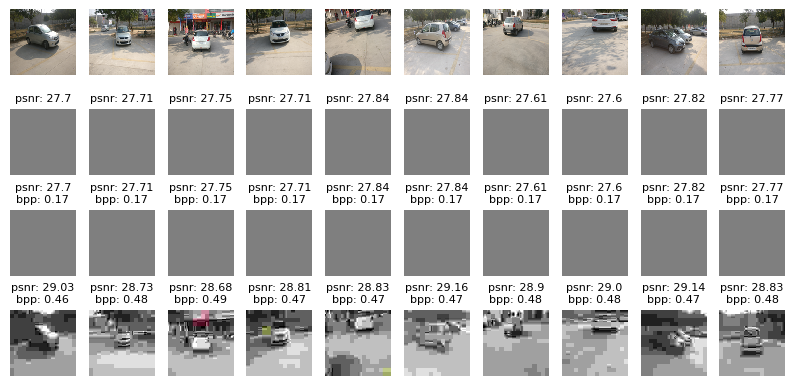

In [12]:
img_count = 10
font_size = 8
save_compare_plot = f'./{MODEL_TYPE}_compare_plot.jpeg'

plt.figure(figsize=(10,5))

for i in range(img_count):
    title = ''
    plt.subplot(4, img_count, i + 1).set_title(title, fontsize=font_size )
    plt.imshow(orig_images[i], interpolation='nearest')
    plt.axis(False)

for i in range(img_count):
    title = f"psnr: {round(vqvae_psnr[i],2)}"
    plt.subplot(4, img_count, img_count + i + 1).set_title(title, fontsize=font_size )
    plt.imshow(vqvae_images[i], interpolation='nearest')
    plt.axis(False)

for i in range(img_count):
    title = f"psnr: {round(quand_psnr[i],2)}\nbpp: {round(bpp[i],2)}"
    plt.subplot(4,img_count, 2*img_count + i + 1).set_title(title, fontsize=font_size )
    plt.imshow(decompressed_images[i], interpolation='nearest')
    plt.axis(False)

for i in range(img_count):
    title = f"psnr: {round(jpeg_psnr[i],2)}\nbpp: {round(jpeg_bpp[i],2)}"
    plt.subplot(4, img_count, 3*img_count + i + 1).set_title(title, fontsize=font_size )
    plt.imshow(jpeg_images[i], interpolation='nearest')
    plt.axis(False)

plt.savefig(save_compare_plot)
plt.show()